Import libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
from metrics import print_evaluation_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order and seasonal order

In [4]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=55241.965, Time=38.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=55288.499, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=55280.100, Time=2.66 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=55281.200, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=55287.358, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=55268.795, Time=36.19 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=55265.686, Time=29.91 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=55239.819, Time=90.49 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=55251.746, Time=54.44 sec
 ARIMA(2,1,2)(3,0,1)[12] intercept   : AIC=55247.370, Time=264.29 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=100.06 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=55242.539, Time=85.88 sec
 ARIMA(2,1,2)(3,0,0)[12] intercept   : AIC=55243.585, Time=303.51 sec
 ARIMA(2,1,2)(3,0,2)[12] intercept   : AIC=55235.566, Time=315.75 sec
 ARIMA(2,1,2)(3,0,3)[12] intercept   : A

Create Model

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train[target_column], order=best_order, seasonal_order=best_seasonal_order
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08576D+00    |proj g|=  1.77553D-02


 This problem is unconstrained.



At iterate    5    f=  8.08484D+00    |proj g|=  8.78588D-03

At iterate   10    f=  8.08473D+00    |proj g|=  4.31404D-03

At iterate   15    f=  8.08462D+00    |proj g|=  9.90516D-05

At iterate   20    f=  8.08461D+00    |proj g|=  2.12703D-03

At iterate   25    f=  8.08430D+00    |proj g|=  5.08175D-03

At iterate   30    f=  8.08399D+00    |proj g|=  2.71621D-03

At iterate   35    f=  8.08378D+00    |proj g|=  1.05216D-03

At iterate   40    f=  8.08371D+00    |proj g|=  1.77248D-03

At iterate   45    f=  8.08333D+00    |proj g|=  3.10888D-03

At iterate   50    f=  8.08310D+00    |proj g|=  3.04072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      Close   No. Observations:                 3077
Model:             SARIMAX(2, 1, 2)x(2, 0, [1, 2, 3], 12)   Log Likelihood              -24871.694
Date:                                    Thu, 07 Mar 2024   AIC                          49763.388
Time:                                            14:57:31   BIC                          49823.702
Sample:                                        09-24-2014   HQIC                         49785.055
                                             - 02-25-2023                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9170      0.009    217.279      0.000       1.900       1.934
ar.L2         -0.9738      0.009   -114.133      0.000      -0.990      -0.957
ma.L1         -1.9195      0.008   -246.122      0.000      -1.935      -1.904
ma.L2          0.9795      0.008    129.588      0.000       0.965       0.994
ar.S.L12       0.2480      0.072      3.443      0.001       0.107       0.389
ar.S.L24       0.6250      0.067      9.356      0.000       0.494       0.756
ma.S.L12      -0.3019      0.073     -4.119      0.000      -0.446      -0.158
ma.S.L24      -0.5370      0.069     -7.764      0.000      -0.673      -0.401
ma.S.L36      -0.0557      0.010     -5.314      0.000      -0.076      -0.035
sigma2      6.273e+05   5588.265    112.250      0.000    6.16e+05    6.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):             33024.19
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):            1605.44   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.3e+14. Standard errors may be unstable.
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


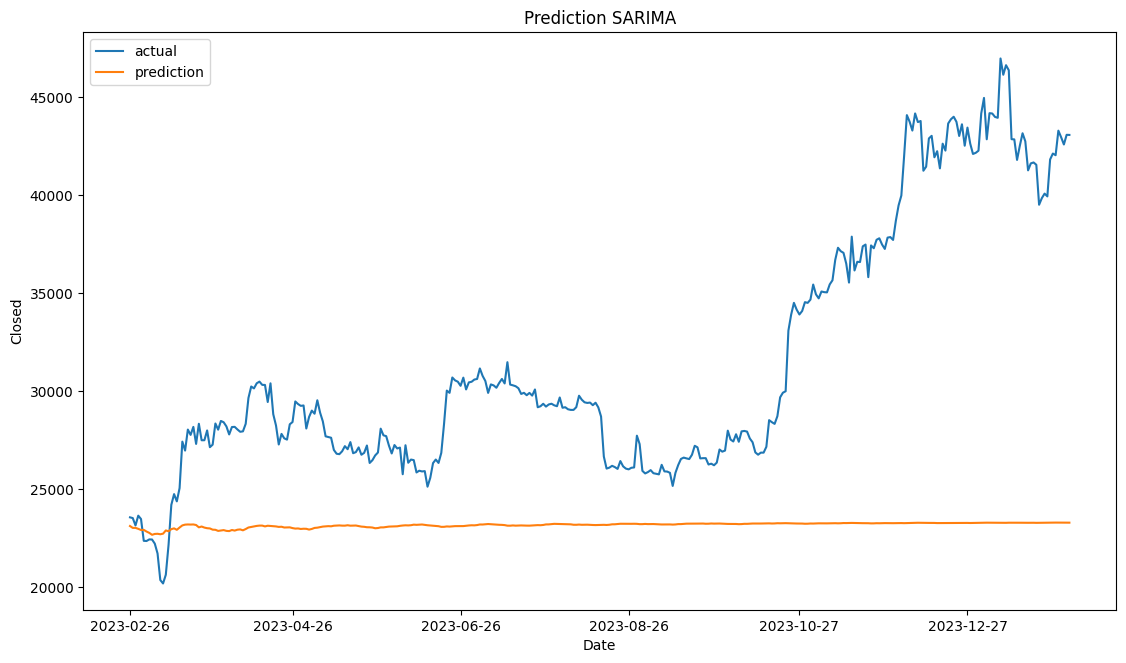

In [6]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], test[target_column].values, label="actual")
ax.plot(dates[int(data_length*train_split):], list(pred), label="prediction")
ax.set_title("Prediction SARIMA")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [7]:
non_zero = []
import sys
 
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test[target_column])

Evaluation Metrics:
MSE: 107246113.71
RMSE: 10355.97
MAE: 8300.65
MAPE: 23.85
SMAPE: 28.36
